#Introduction

We took our best model up to now, and we decided to perform all separate predictions, to see if something changes (we thought that the training could not have considered the different ranges of the signals). Unfortunately, this didn't improve our results (almost nothing changed with respect to when the seven time series were trained all together).

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=c18c6f7c5ccade28cacc0851d69351619b732e87f7c59748496420360371fc8f
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_win90st5_allSeparate_5_MemeCreativity' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


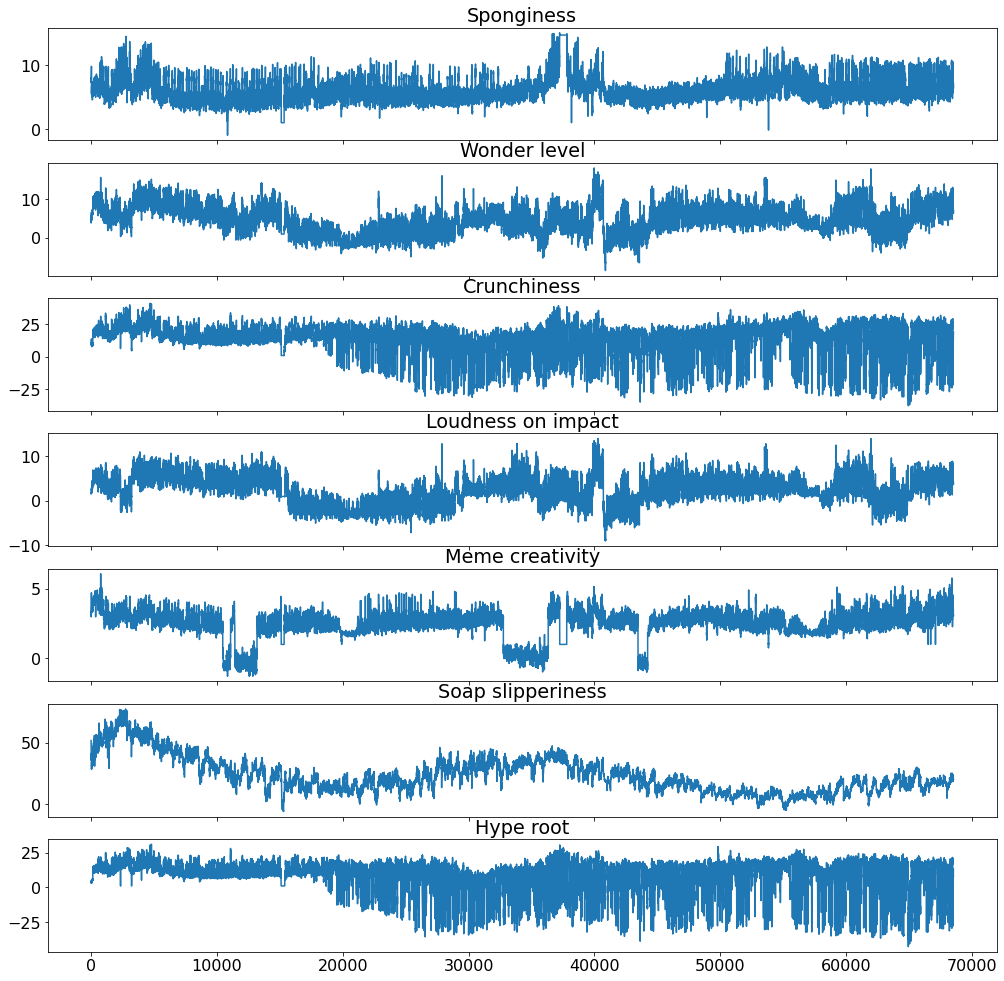

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


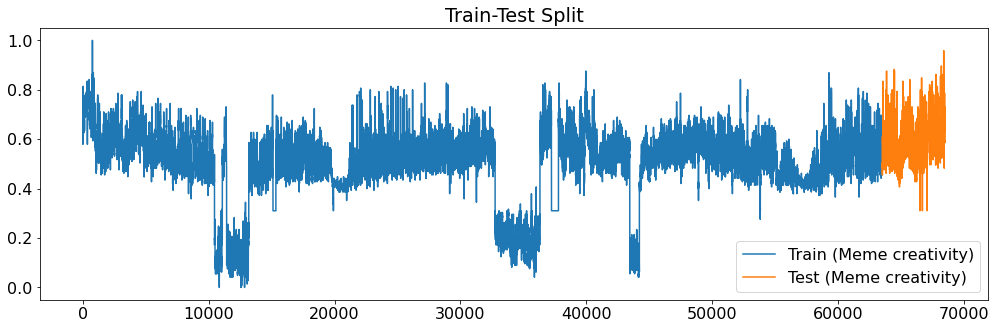

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Meme creativity'], label='Train (Meme creativity)')
plt.plot(X_test_raw['Meme creativity'], label='Test (Meme creativity)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 90, 7)


In [ ]:
def build_sequences(df, target_labels=['Meme creativity'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    index_of_column = 4
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,2))
    #for col in enumerate(columns):
    axs.plot(np.arange(len(X[0,:,index_of_column])), X[idx,:,index_of_column])
    axs.scatter(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), y[idx,:], color='orange')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

# Forecasting

In [ ]:
target_labels = ['Meme creativity']
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12518, 90, 7), (12518, 864, 1), (818, 90, 7), (818, 864, 1))

In [ ]:
#inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 1)


(None, 90, 512)
(None, 90, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 512)          540672    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 90, 512)          32833     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 864)               443232    
                             

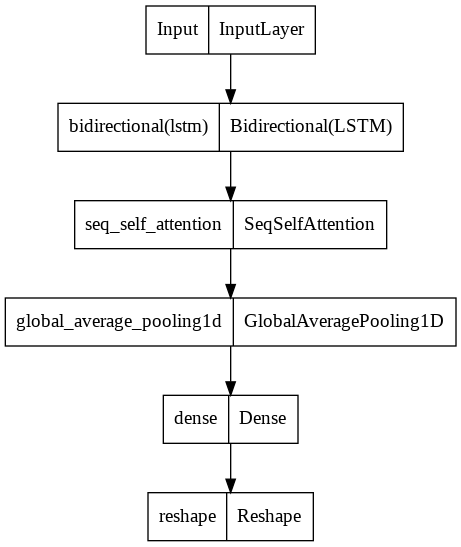

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# restore checkpoints:
#model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0506 - mae: 0.1427 - rmse: 0.2250

1409/1409 [==============================] - 58s 31ms/step - loss: 0.0506 - mae: 0.1427 - rmse: 0.2250 - val_loss: 0.0362 - val_mae: 0.1135 - val_rmse: 0.1902 - lr: 0.0010
Epoch 2/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0356 - mae: 0.1149 - rmse: 0.1887

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0356 - mae: 0.1149 - rmse: 0.1887 - val_loss: 0.0259 - val_mae: 0.0972 - val_rmse: 0.1610 - lr: 0.0010
Epoch 3/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0231 - mae: 0.0944 - rmse: 0.1521

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0231 - mae: 0.0944 - rmse: 0.1521 - val_loss: 0.0090 - val_mae: 0.0612 - val_rmse: 0.0950 - lr: 0.0010
Epoch 4/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0151 - mae: 0.0799 - rmse: 0.1228

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0151 - mae: 0.0799 - rmse: 0.1228 - val_loss: 0.0092 - val_mae: 0.0663 - val_rmse: 0.0957 - lr: 0.0010
Epoch 5/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0150 - mae: 0.0801 - rmse: 0.1223

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0150 - mae: 0.0801 - rmse: 0.1223 - val_loss: 0.0084 - val_mae: 0.0663 - val_rmse: 0.0914 - lr: 0.0010
Epoch 6/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0134 - mae: 0.0764 - rmse: 0.1160

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0134 - mae: 0.0764 - rmse: 0.1160 - val_loss: 0.0071 - val_mae: 0.0575 - val_rmse: 0.0840 - lr: 0.0010
Epoch 7/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0122 - mae: 0.0731 - rmse: 0.1105

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0122 - mae: 0.0731 - rmse: 0.1105 - val_loss: 0.0066 - val_mae: 0.0597 - val_rmse: 0.0810 - lr: 0.0010
Epoch 8/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0117 - mae: 0.0723 - rmse: 0.1083

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0117 - mae: 0.0723 - rmse: 0.1083 - val_loss: 0.0065 - val_mae: 0.0612 - val_rmse: 0.0806 - lr: 0.0010
Epoch 9/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0113 - mae: 0.0708 - rmse: 0.1064

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0113 - mae: 0.0708 - rmse: 0.1064 - val_loss: 0.0063 - val_mae: 0.0597 - val_rmse: 0.0791 - lr: 0.0010
Epoch 10/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0111 - mae: 0.0703 - rmse: 0.1056

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0111 - mae: 0.0703 - rmse: 0.1056 - val_loss: 0.0058 - val_mae: 0.0578 - val_rmse: 0.0760 - lr: 0.0010
Epoch 11/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0111 - mae: 0.0706 - rmse: 0.1053

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0111 - mae: 0.0706 - rmse: 0.1053 - val_loss: 0.0057 - val_mae: 0.0571 - val_rmse: 0.0755 - lr: 0.0010
Epoch 12/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0108 - mae: 0.0703 - rmse: 0.1041

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0108 - mae: 0.0703 - rmse: 0.1041 - val_loss: 0.0051 - val_mae: 0.0568 - val_rmse: 0.0711 - lr: 0.0010
Epoch 13/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0099 - mae: 0.0680 - rmse: 0.0997

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0099 - mae: 0.0680 - rmse: 0.0997 - val_loss: 0.0049 - val_mae: 0.0563 - val_rmse: 0.0701 - lr: 0.0010
Epoch 14/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0678 - rmse: 0.0992

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0098 - mae: 0.0678 - rmse: 0.0992 - val_loss: 0.0045 - val_mae: 0.0523 - val_rmse: 0.0668 - lr: 0.0010
Epoch 15/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0679 - rmse: 0.0992

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0099 - mae: 0.0680 - rmse: 0.0993 - val_loss: 0.0043 - val_mae: 0.0509 - val_rmse: 0.0652 - lr: 0.0010
Epoch 16/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0097 - mae: 0.0672 - rmse: 0.0987

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0097 - mae: 0.0672 - rmse: 0.0987 - val_loss: 0.0043 - val_mae: 0.0517 - val_rmse: 0.0655 - lr: 0.0010
Epoch 17/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0662 - rmse: 0.0972

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0095 - mae: 0.0662 - rmse: 0.0972 - val_loss: 0.0045 - val_mae: 0.0541 - val_rmse: 0.0671 - lr: 0.0010
Epoch 18/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0652 - rmse: 0.0952

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0091 - mae: 0.0652 - rmse: 0.0952 - val_loss: 0.0049 - val_mae: 0.0575 - val_rmse: 0.0699 - lr: 0.0010
Epoch 19/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0089 - mae: 0.0646 - rmse: 0.0943

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0089 - mae: 0.0646 - rmse: 0.0943 - val_loss: 0.0045 - val_mae: 0.0535 - val_rmse: 0.0668 - lr: 0.0010
Epoch 20/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0087 - mae: 0.0639 - rmse: 0.0933

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0087 - mae: 0.0639 - rmse: 0.0934 - val_loss: 0.0046 - val_mae: 0.0551 - val_rmse: 0.0680 - lr: 0.0010
Epoch 21/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0083 - mae: 0.0624 - rmse: 0.0910

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0083 - mae: 0.0624 - rmse: 0.0910 - val_loss: 0.0042 - val_mae: 0.0522 - val_rmse: 0.0648 - lr: 5.0000e-04
Epoch 22/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0619 - rmse: 0.0902

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0081 - mae: 0.0619 - rmse: 0.0902 - val_loss: 0.0041 - val_mae: 0.0515 - val_rmse: 0.0640 - lr: 5.0000e-04
Epoch 23/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0620 - rmse: 0.0903

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0082 - mae: 0.0620 - rmse: 0.0903 - val_loss: 0.0043 - val_mae: 0.0533 - val_rmse: 0.0653 - lr: 5.0000e-04
Epoch 24/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0080 - mae: 0.0614 - rmse: 0.0894

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0080 - mae: 0.0614 - rmse: 0.0894 - val_loss: 0.0041 - val_mae: 0.0514 - val_rmse: 0.0640 - lr: 5.0000e-04
Epoch 25/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0082 - mae: 0.0620 - rmse: 0.0903

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0082 - mae: 0.0620 - rmse: 0.0903 - val_loss: 0.0041 - val_mae: 0.0517 - val_rmse: 0.0639 - lr: 5.0000e-04
Epoch 26/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0610 - rmse: 0.0888

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0079 - mae: 0.0610 - rmse: 0.0888 - val_loss: 0.0040 - val_mae: 0.0506 - val_rmse: 0.0630 - lr: 5.0000e-04
Epoch 27/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0605 - rmse: 0.0880

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0078 - mae: 0.0605 - rmse: 0.0880 - val_loss: 0.0040 - val_mae: 0.0514 - val_rmse: 0.0630 - lr: 5.0000e-04
Epoch 28/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0609 - rmse: 0.0885

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0078 - mae: 0.0609 - rmse: 0.0885 - val_loss: 0.0039 - val_mae: 0.0508 - val_rmse: 0.0628 - lr: 5.0000e-04
Epoch 29/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0077 - mae: 0.0605 - rmse: 0.0876

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0077 - mae: 0.0605 - rmse: 0.0875 - val_loss: 0.0038 - val_mae: 0.0482 - val_rmse: 0.0616 - lr: 5.0000e-04
Epoch 30/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0603 - rmse: 0.0872

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0076 - mae: 0.0603 - rmse: 0.0872 - val_loss: 0.0038 - val_mae: 0.0481 - val_rmse: 0.0618 - lr: 5.0000e-04
Epoch 31/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0080 - mae: 0.0615 - rmse: 0.0893

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0080 - mae: 0.0614 - rmse: 0.0892 - val_loss: 0.0038 - val_mae: 0.0480 - val_rmse: 0.0613 - lr: 5.0000e-04
Epoch 32/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0605 - rmse: 0.0870

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0076 - mae: 0.0605 - rmse: 0.0870 - val_loss: 0.0039 - val_mae: 0.0482 - val_rmse: 0.0621 - lr: 5.0000e-04
Epoch 33/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0592 - rmse: 0.0858

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0074 - mae: 0.0592 - rmse: 0.0858 - val_loss: 0.0037 - val_mae: 0.0471 - val_rmse: 0.0608 - lr: 5.0000e-04
Epoch 34/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0601 - rmse: 0.0874

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0076 - mae: 0.0601 - rmse: 0.0874 - val_loss: 0.0037 - val_mae: 0.0477 - val_rmse: 0.0610 - lr: 5.0000e-04
Epoch 35/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0591 - rmse: 0.0865

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0075 - mae: 0.0591 - rmse: 0.0865 - val_loss: 0.0036 - val_mae: 0.0470 - val_rmse: 0.0600 - lr: 5.0000e-04
Epoch 36/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0608 - rmse: 0.0883

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0078 - mae: 0.0608 - rmse: 0.0883 - val_loss: 0.0037 - val_mae: 0.0484 - val_rmse: 0.0612 - lr: 5.0000e-04
Epoch 37/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0589 - rmse: 0.0849

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0072 - mae: 0.0589 - rmse: 0.0849 - val_loss: 0.0039 - val_mae: 0.0500 - val_rmse: 0.0622 - lr: 5.0000e-04
Epoch 38/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0584 - rmse: 0.0839

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0070 - mae: 0.0584 - rmse: 0.0839 - val_loss: 0.0040 - val_mae: 0.0496 - val_rmse: 0.0630 - lr: 5.0000e-04
Epoch 39/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0583 - rmse: 0.0842

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0071 - mae: 0.0583 - rmse: 0.0842 - val_loss: 0.0039 - val_mae: 0.0477 - val_rmse: 0.0621 - lr: 5.0000e-04
Epoch 40/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0585 - rmse: 0.0850

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0072 - mae: 0.0585 - rmse: 0.0850 - val_loss: 0.0037 - val_mae: 0.0493 - val_rmse: 0.0610 - lr: 5.0000e-04
Epoch 41/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0558 - rmse: 0.0799

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0064 - mae: 0.0558 - rmse: 0.0800 - val_loss: 0.0036 - val_mae: 0.0461 - val_rmse: 0.0600 - lr: 2.5000e-04
Epoch 42/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794 - val_loss: 0.0034 - val_mae: 0.0460 - val_rmse: 0.0587 - lr: 2.5000e-04
Epoch 43/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0552 - rmse: 0.0796

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0063 - mae: 0.0552 - rmse: 0.0796 - val_loss: 0.0035 - val_mae: 0.0468 - val_rmse: 0.0592 - lr: 2.5000e-04
Epoch 44/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0547 - rmse: 0.0781

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0061 - mae: 0.0547 - rmse: 0.0781 - val_loss: 0.0034 - val_mae: 0.0464 - val_rmse: 0.0587 - lr: 2.5000e-04
Epoch 45/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0543 - rmse: 0.0771

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0059 - mae: 0.0543 - rmse: 0.0771 - val_loss: 0.0038 - val_mae: 0.0494 - val_rmse: 0.0613 - lr: 2.5000e-04
Epoch 46/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0545 - rmse: 0.0778

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0060 - mae: 0.0545 - rmse: 0.0777 - val_loss: 0.0036 - val_mae: 0.0467 - val_rmse: 0.0598 - lr: 2.5000e-04
Epoch 47/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0536 - rmse: 0.0761

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0058 - mae: 0.0536 - rmse: 0.0761 - val_loss: 0.0036 - val_mae: 0.0471 - val_rmse: 0.0601 - lr: 2.5000e-04
Epoch 48/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0525 - rmse: 0.0738

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0054 - mae: 0.0524 - rmse: 0.0738 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0591 - lr: 1.2500e-04
Epoch 49/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0522 - rmse: 0.0731

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0053 - mae: 0.0522 - rmse: 0.0731 - val_loss: 0.0034 - val_mae: 0.0459 - val_rmse: 0.0587 - lr: 1.2500e-04
Epoch 50/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0517 - rmse: 0.0727

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0053 - mae: 0.0518 - rmse: 0.0727 - val_loss: 0.0034 - val_mae: 0.0457 - val_rmse: 0.0587 - lr: 1.2500e-04
Epoch 51/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0516 - rmse: 0.0727

1409/1409 [==============================] - 47s 34ms/step - loss: 0.0053 - mae: 0.0516 - rmse: 0.0727 - val_loss: 0.0035 - val_mae: 0.0463 - val_rmse: 0.0595 - lr: 1.2500e-04
Epoch 52/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0517 - rmse: 0.0730

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0053 - mae: 0.0517 - rmse: 0.0730 - val_loss: 0.0035 - val_mae: 0.0458 - val_rmse: 0.0595 - lr: 1.2500e-04
Epoch 53/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0510 - rmse: 0.0714

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0713 - val_loss: 0.0035 - val_mae: 0.0459 - val_rmse: 0.0590 - lr: 6.2500e-05
Epoch 54/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0506 - rmse: 0.0706

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0050 - mae: 0.0506 - rmse: 0.0706 - val_loss: 0.0035 - val_mae: 0.0465 - val_rmse: 0.0592 - lr: 6.2500e-05
Epoch 55/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0504 - rmse: 0.0704

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0050 - mae: 0.0504 - rmse: 0.0704 - val_loss: 0.0035 - val_mae: 0.0456 - val_rmse: 0.0588 - lr: 6.2500e-05
Epoch 56/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0503 - rmse: 0.0701

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0049 - mae: 0.0503 - rmse: 0.0701 - val_loss: 0.0035 - val_mae: 0.0460 - val_rmse: 0.0590 - lr: 6.2500e-05
Epoch 57/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0505 - rmse: 0.0705

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0050 - mae: 0.0505 - rmse: 0.0705 - val_loss: 0.0035 - val_mae: 0.0462 - val_rmse: 0.0590 - lr: 6.2500e-05
Epoch 58/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0499 - rmse: 0.0695

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0048 - mae: 0.0499 - rmse: 0.0694 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0590 - lr: 3.1250e-05
Epoch 59/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0497 - rmse: 0.0693

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0048 - mae: 0.0497 - rmse: 0.0693 - val_loss: 0.0035 - val_mae: 0.0463 - val_rmse: 0.0592 - lr: 3.1250e-05
Epoch 60/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0496 - rmse: 0.0691

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0048 - mae: 0.0496 - rmse: 0.0691 - val_loss: 0.0035 - val_mae: 0.0461 - val_rmse: 0.0590 - lr: 3.1250e-05
Epoch 61/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0496 - rmse: 0.0691

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0048 - mae: 0.0496 - rmse: 0.0691 - val_loss: 0.0035 - val_mae: 0.0462 - val_rmse: 0.0592 - lr: 3.1250e-05
Epoch 62/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0496 - rmse: 0.0690

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0048 - mae: 0.0496 - rmse: 0.0690 - val_loss: 0.0035 - val_mae: 0.0461 - val_rmse: 0.0589 - lr: 3.1250e-05
Epoch 63/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0493 - rmse: 0.0686

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0047 - mae: 0.0493 - rmse: 0.0686 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0590 - lr: 1.5625e-05
Epoch 64/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0493 - rmse: 0.0686

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0047 - mae: 0.0493 - rmse: 0.0686 - val_loss: 0.0035 - val_mae: 0.0463 - val_rmse: 0.0591 - lr: 1.5625e-05
Epoch 65/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0493 - rmse: 0.0686

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0047 - mae: 0.0493 - rmse: 0.0685 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0591 - lr: 1.5625e-05
Epoch 66/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0492 - rmse: 0.0685

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0047 - mae: 0.0492 - rmse: 0.0685 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0591 - lr: 1.5625e-05
Epoch 67/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0492 - rmse: 0.0684

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0047 - mae: 0.0492 - rmse: 0.0684 - val_loss: 0.0035 - val_mae: 0.0465 - val_rmse: 0.0592 - lr: 1.5625e-05
Epoch 68/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0491 - rmse: 0.0683

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0047 - mae: 0.0491 - rmse: 0.0683 - val_loss: 0.0035 - val_mae: 0.0461 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 69/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0491 - rmse: 0.0683

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0047 - mae: 0.0491 - rmse: 0.0683 - val_loss: 0.0035 - val_mae: 0.0463 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 70/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0491 - rmse: 0.0681

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0491 - rmse: 0.0681 - val_loss: 0.0035 - val_mae: 0.0462 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 71/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0491 - rmse: 0.0682

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0490 - rmse: 0.0681 - val_loss: 0.0035 - val_mae: 0.0463 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 72/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0490 - rmse: 0.0681

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0490 - rmse: 0.0681 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 73/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0490 - rmse: 0.0681

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0490 - rmse: 0.0681 - val_loss: 0.0035 - val_mae: 0.0462 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 74/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0490 - rmse: 0.0680

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0490 - rmse: 0.0680 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0592 - lr: 1.0000e-05
Epoch 75/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0491 - rmse: 0.0680

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0490 - rmse: 0.0681 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0593 - lr: 1.0000e-05
Epoch 76/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0489 - rmse: 0.0680

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0489 - rmse: 0.0680 - val_loss: 0.0035 - val_mae: 0.0462 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 77/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0489 - rmse: 0.0679

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0489 - rmse: 0.0679 - val_loss: 0.0035 - val_mae: 0.0463 - val_rmse: 0.0591 - lr: 1.0000e-05
Epoch 78/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0489 - rmse: 0.0679

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0489 - rmse: 0.0679 - val_loss: 0.0035 - val_mae: 0.0463 - val_rmse: 0.0593 - lr: 1.0000e-05
Epoch 79/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0489 - rmse: 0.0679

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0489 - rmse: 0.0679 - val_loss: 0.0035 - val_mae: 0.0464 - val_rmse: 0.0593 - lr: 1.0000e-05


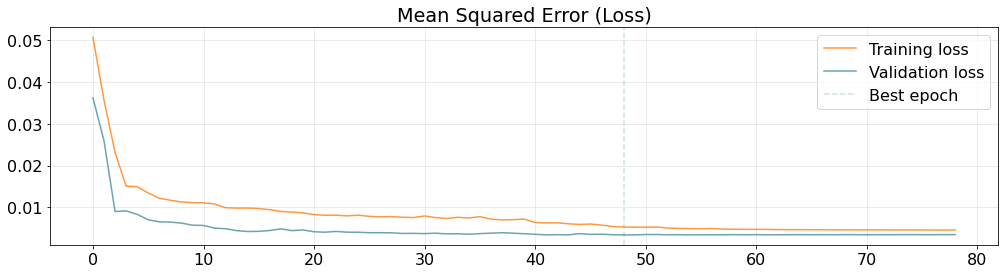

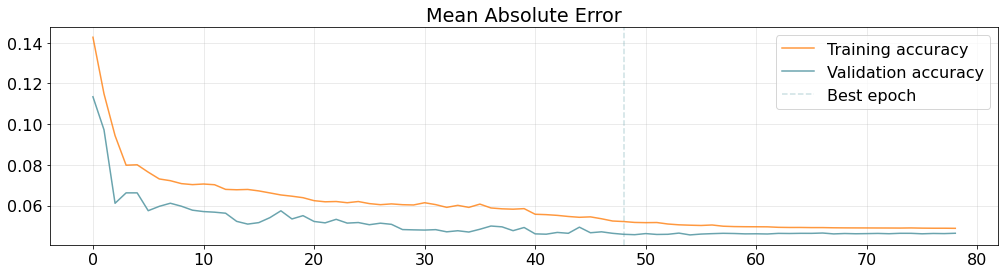

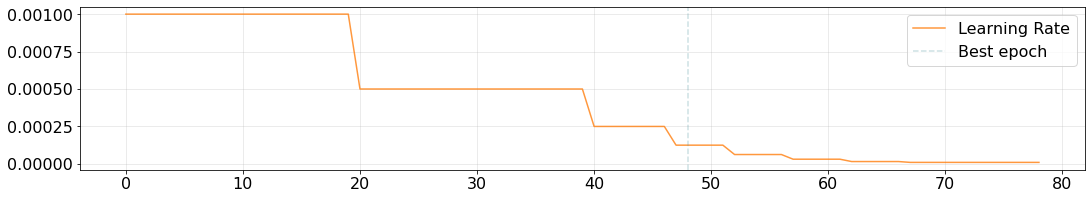

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Models/'+title)
#model = tfk.models.load_model('Models/'+title)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(818, 864, 1)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.010179414>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07752334>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    index_of_column = 4
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,2))
    #for i, col in enumerate(columns):
    axs.plot(np.arange(len(X[0,:,index_of_column])), X[idx,:,index_of_column])
    axs.plot(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), pred[idx,:], color='green')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

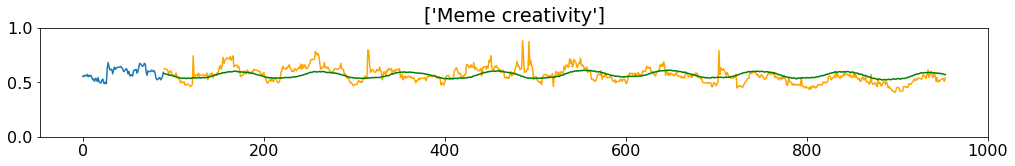

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)